In [3]:
import imageio.v3 as iio
import os
import numpy as np
import matplotlib.pyplot as plt

In [35]:
import pandas as pd
from PIL import Image
image_paths = "./archive_res/the_wildfire_dataset_2n_version"
df_images = pd.DataFrame()
separation = sorted(os.listdir(image_paths))
lables = {
    "nofire": False,
    "fire": True 
}
for sep in separation:
    for label in os.listdir(f"{image_paths}/{sep}"):
        for image in os.listdir(f"{image_paths}/{sep}/{label}"):
            if not image.endswith(".jpg"):
                continue
            #os.makedirs(f"./archive_res/the_wildfire_dataset_2n_version/{sep}/{label}", exist_ok=True)
            
            #img = Image.open(f"{image_paths}/{sep}/{label}/{image}")
            #out = img.resize((224,224))
            #out.save(f"./archive_res/the_wildfire_dataset_2n_version/{sep}/{label}/{image}")
            
            new_row = pd.DataFrame([{
                "path": image,
                "type": sep,
                "label": lables[label]
            }])
            df_images = pd.concat([df_images, new_row]).reset_index(drop=True)

df_images.to_csv("images.csv", index=False)


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import decode_image
from torch.utils.data import Dataset

In [6]:
image_paths = "./archive_res/the_wildfire_dataset_2n_version"

class CustomImageDataset(Dataset):
    def __init__(self, img_dirs, annotations_file, transform=None, target_transform=None):
        self.img_dirs = img_dirs
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.target_transform = target_transform
        self.labels = ["nofire", "fire"]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = 1 if self.img_labels.iloc[idx, 2] else 0
        typ = self.img_labels.iloc[idx, 1]
        img_path = self.img_labels.iloc[idx, 0]
        image = decode_image(os.path.join(f"{self.img_dirs}/{typ}/{self.labels[label]}",img_path), mode="RGB")
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
full_images = CustomImageDataset(image_paths, "images.csv", transform)

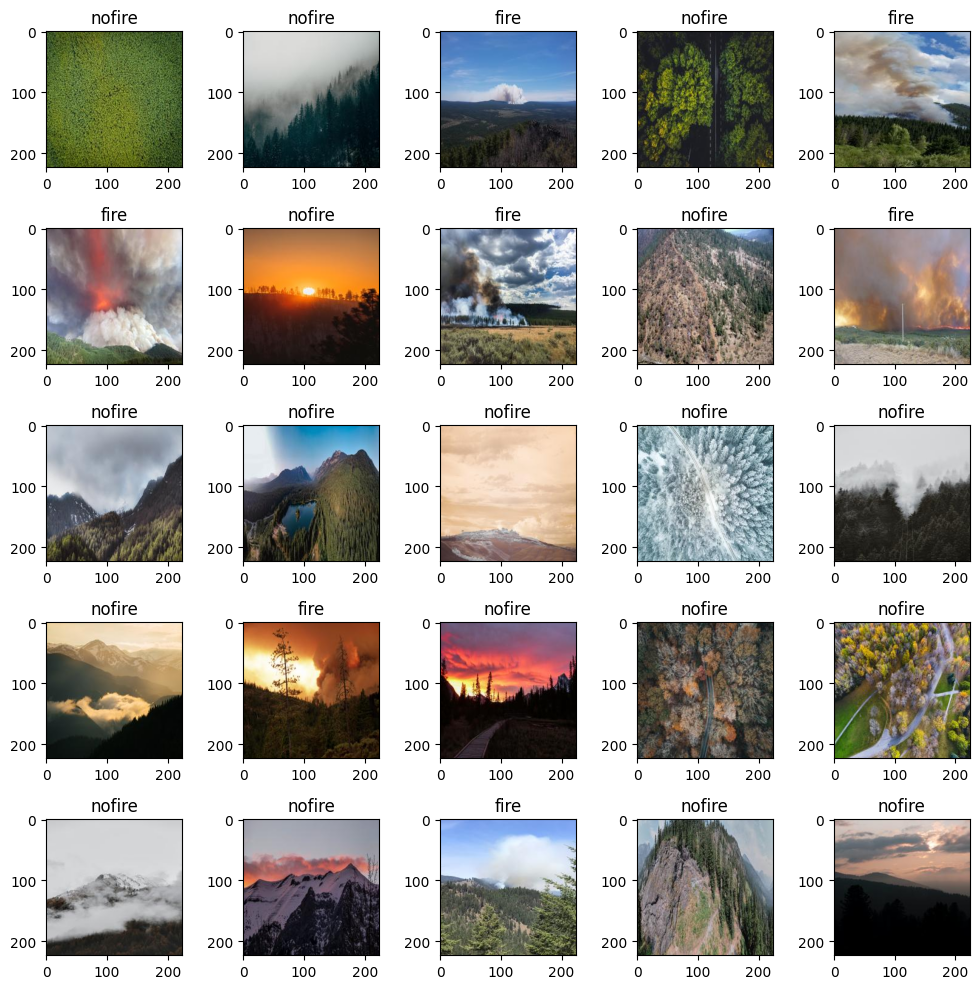

In [ ]:
from random import randint
n = 5

fig, ax = plt.subplots(n, n, figsize=(10, 10))

for i in range(n*n):
  i_random = randint(0, len(full_images))
  img = full_images[i_random][0] / 2 + 0.5
  npimg = img.numpy()
  ax[i // n, i % n].imshow(np.transpose(npimg, (1, 2, 0)))
  ax[i // n, i % n].set_title(full_images.labels[full_images[i_random][1]])

fig.tight_layout()
plt.show()

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [11]:
import torchvision.models as models

model = models.mobilenet_v3_small(pretrained=True).to(device)

# Freeze all pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the last layer
in_features = model.classifier[-1].in_features
# Define the number of output classes for your task
num_classes = 1  # Replace with your number of classes
# Create a new linear layer with the new output size
new_classifier = torch.nn.Linear(in_features, num_classes)
sigmoid = torch.nn.Sigmoid()

model.classifier[-1] = torch.nn.Linear(in_features, 1)
model.classifier.append(torch.nn.Sigmoid())

/home/lelio/USP/sem7/pdi/pdi_env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lelio/USP/sem7/pdi/pdi_env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1, bias=True)
  (4): Sigmoid()
)

In [12]:
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [13]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_images, [0.70, 0.15, 0.15])

In [14]:
from torch.utils.data import DataLoader

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2),
    "val": DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2),
    "test": DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2),
}

In [15]:
import time
from tempfile import TemporaryDirectory

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

def choose_label(outputs):
    return (outputs > 0.5).detach().numpy().reshape(-1).astype(int)

def train_model(model, criterion, choose_label, device, optimizer, num_epochs=25):
    since = time.time()

    best_acc = 0.0

    with TemporaryDirectory() as tempdir: 
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0  
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                loss = None
                preds = []

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        preds = choose_label(outputs)
                        loss = criterion(outputs, labels.unsqueeze(1).float())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model


In [16]:
criterion = torch.nn.BCELoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
model = train_model(model, criterion, choose_label, device, optimizer_ft, num_epochs=10)

Epoch 0/9
----------


train Loss: 0.5806 Acc: 0.7219
val Loss: 0.5121 Acc: 0.7886

Epoch 1/9
----------
train Loss: 0.4389 Acc: 0.8210
val Loss: 0.4336 Acc: 0.8159

Epoch 2/9
----------
train Loss: 0.3816 Acc: 0.8455
val Loss: 0.3840 Acc: 0.8607

Epoch 3/9
----------
train Loss: 0.3490 Acc: 0.8615
val Loss: 0.3578 Acc: 0.8657

Epoch 4/9
----------
train Loss: 0.3297 Acc: 0.8780
val Loss: 0.3414 Acc: 0.8682

Epoch 5/9
----------
train Loss: 0.3134 Acc: 0.8780
val Loss: 0.3247 Acc: 0.8756

Epoch 6/9
----------
train Loss: 0.2978 Acc: 0.8833
val Loss: 0.3133 Acc: 0.8781

Epoch 7/9
----------
train Loss: 0.2903 Acc: 0.8855
val Loss: 0.3010 Acc: 0.8756

Epoch 8/9
----------
train Loss: 0.2792 Acc: 0.8918
val Loss: 0.2921 Acc: 0.8831

Epoch 9/9
----------
train Loss: 0.2802 Acc: 0.8897
val Loss: 0.2847 Acc: 0.8905

Training complete in 3m 20s
Best val Acc: 0.890547


## Testando

In [18]:
dataiter = iter(dataloaders["test"])
images, labels = next(dataiter)
# print images
print(f'GroundTruth: {[full_images.labels[labels[j]] for j in range(len(labels))]}')

GroundTruth: ['nofire', 'nofire', 'nofire', 'nofire', 'fire', 'nofire', 'nofire', 'nofire', 'fire', 'nofire', 'fire', 'fire', 'nofire', 'fire', 'fire', 'nofire', 'nofire', 'nofire', 'nofire', 'nofire', 'nofire', 'fire', 'fire', 'fire', 'fire', 'fire', 'nofire', 'nofire', 'nofire', 'nofire', 'nofire', 'fire', 'fire', 'nofire', 'fire', 'fire', 'nofire', 'nofire', 'fire', 'nofire', 'nofire', 'fire', 'fire', 'fire', 'nofire', 'nofire', 'fire', 'nofire', 'nofire', 'fire', 'nofire', 'fire', 'fire', 'fire', 'fire', 'fire', 'nofire', 'fire', 'fire', 'nofire', 'nofire', 'nofire', 'fire', 'fire']


In [19]:
outputs = model(images)
preds = choose_label(outputs)
print(f'Predicted: {[full_images.labels[preds[j]] for j in range(len(labels))]}')
print(f"Accuracy: {torch.sum(labels.data == preds)/len(labels)}")

Predicted: ['nofire', 'nofire', 'nofire', 'nofire', 'fire', 'nofire', 'nofire', 'nofire', 'fire', 'nofire', 'fire', 'nofire', 'nofire', 'fire', 'nofire', 'nofire', 'nofire', 'nofire', 'nofire', 'nofire', 'nofire', 'fire', 'fire', 'fire', 'fire', 'fire', 'nofire', 'nofire', 'nofire', 'nofire', 'nofire', 'fire', 'fire', 'nofire', 'fire', 'fire', 'nofire', 'nofire', 'fire', 'nofire', 'nofire', 'fire', 'fire', 'fire', 'nofire', 'fire', 'fire', 'nofire', 'nofire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'nofire', 'nofire', 'fire', 'fire', 'nofire', 'nofire', 'fire', 'nofire']
Accuracy: 0.890625


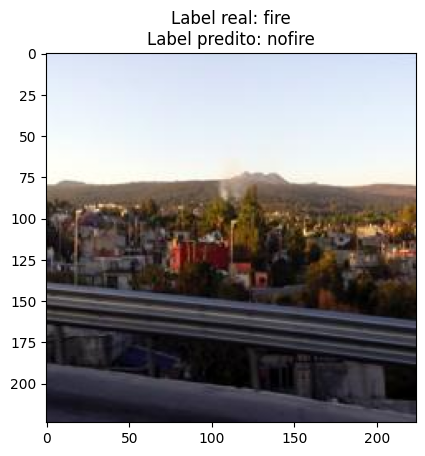

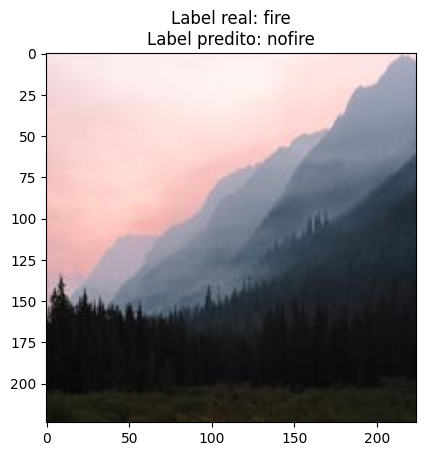

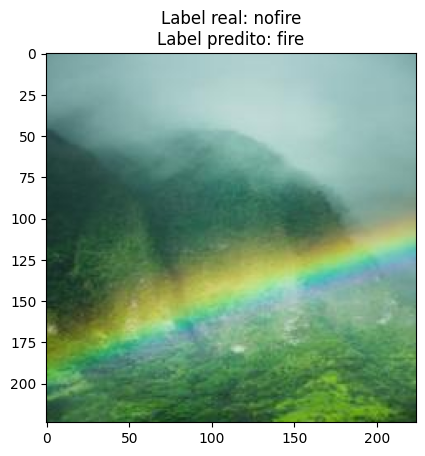

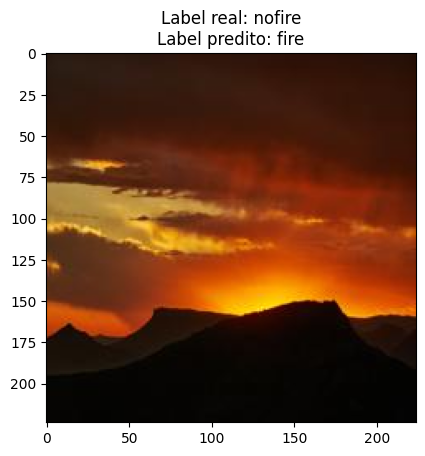

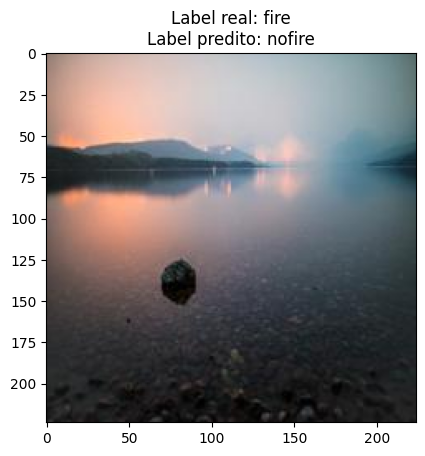

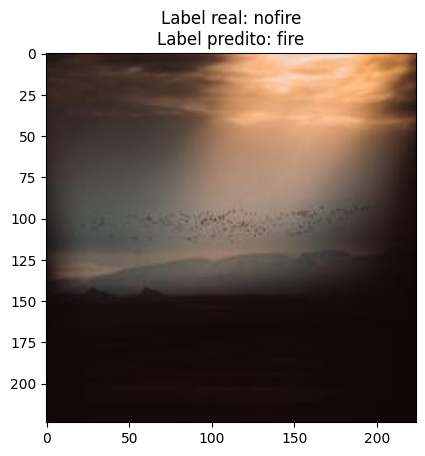

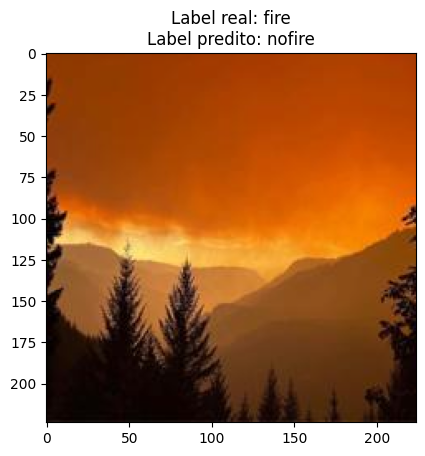

In [34]:
for i in range(len(labels)):
    if labels[i] != preds[i]:
        img = images[i] / 2 + 0.5
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"Label real: {full_images.labels[labels[i]]}\nLabel predito: {full_images.labels[preds[i]]}")
        plt.show()